In [1]:
# Определяем класс, представляющий индивида (особь) в популяции
class Individual:
    def __init__(self, chromosome):
        # Хромосома хранит веса активов для данного индивида
        self.chromosome = chromosome
        # Приспособленность индивида (вычисляется позже)
        self.fitness = None
    
    def __repr__(self):
        # Удобный формат вывода объекта для отладки
        return f"Individual(chromosome={self.chromosome}, fitness={self.fitness})"

In [2]:
# Импортируем модуль random для работы со случайными числами
import random

# Функция для генерации начальной популяции
def generate_initial_population(N, num_assets):
    """
    Генерирует начальную популяцию из N особей (хромосом).
    """
    population = []
    for _ in range(N):
        # Генерация случайных весов для активов (хромосомы)
        weights = [random.random() for _ in range(num_assets)]
        # Нормализация весов, чтобы их сумма была равна 1
        sum_weights = sum(weights)
        normalized_weights = [w / sum_weights for w in weights]
        # Создание индивида с нормализованной хромосомой
        individual = Individual(chromosome=normalized_weights)
        population.append(individual)
    return population

In [3]:
# Функция вычисления приспособленности индивида
def fitness_function(individual, expected_returns):
    """
    Оценка приспособленности особи. Формула: f_fit(xi) = Σ wi * ei
    """
    # Скаларное произведение весов и ожидаемых доходностей
    return sum(w * e for w, e in zip(individual.chromosome, expected_returns))

# Функция оценки всей популяции
def evaluate_population(population, expected_returns):
    """
    Оценивает приспособленность каждой особи в популяции.
    """
    for individual in population:
        # Вычисляем приспособленность каждого индивида
        individual.fitness = fitness_function(individual, expected_returns)

In [4]:
# Реализация селекции методом "рулетка"
def roulette_selection(population, num_parents):
    """
    Реализует селекцию методом "рулетка" для выбора родителей.
    """
    # Вычисляем общую приспособленность популяции
    total_fitness = sum(ind.fitness for ind in population)
    # Рассчитываем вероятность выбора для каждого индивида
    selection_probs = [ind.fitness / total_fitness for ind in population]
    # Случайный выбор родителей с учетом вероятностей
    selected_parents = random.choices(
        population, weights=selection_probs, k=num_parents
    )
    return selected_parents

In [5]:
# Реализация одноточечного кроссовера
def crossover(parent1, parent2):
    """
    Реализует одноточечный кроссовер.
    """
    # Выбираем случайную точку разрыва
    point = random.randint(1, len(parent1.chromosome) - 1)
    # Создаем потомков путем обмена частями хромосом родителей
    child1_chromosome = parent1.chromosome[:point] + parent2.chromosome[point:]
    child2_chromosome = parent2.chromosome[:point] + parent1.chromosome[point:]
    
    return Individual(child1_chromosome), Individual(child2_chromosome)

In [6]:
# Реализация мутации
def mutation(individual, mutation_rate=0.005):
    """
    Реализует мутацию с вероятностью mutation_rate.
    """
    for i in range(len(individual.chromosome)):
        # С вероятностью mutation_rate инвертируем значение гена
        if random.random() < mutation_rate:
            individual.chromosome[i] = 1 - individual.chromosome[i]

In [7]:
# Проверка и корректировка особей
def validate_and_correct_population(population):
    """
    Проверяет, что сумма весов в каждой особи равна 1, и корректирует, если нужно.
    """
    for individual in population:
        # Если сумма весов не равна 1, нормализуем их
        sum_weights = sum(individual.chromosome)
        if sum_weights != 1.0:
            individual.chromosome = [w / sum_weights for w in individual.chromosome]

In [12]:
# Импортируем библиотеку для построения графиков
import matplotlib.pyplot as plt

# Основная функция генетического алгоритма
def genetic_algorithm(
    initial_population, fitness_function, selection_function, 
    crossover_function, mutation_function, validate_function,
    expected_returns, N, max_generations=100, plateau_limit=15, step_by_step=False
):
    population = initial_population
    best_solution = None
    fitness_history = []  # История среднего значения приспособленности
    max_fitness_history = []  # История максимального значения приспособленности
    plateau_counter = 0  # Счетчик стагнации
    last_max_fitness = None  # Последнее максимальное значение приспособленности

    for generation in range(max_generations):
        # Оценка популяции
        evaluate_population(population, expected_returns)
        
        # Сохранение лучших решений для отображения
        max_fitness = max(ind.fitness for ind in population)
        avg_fitness = sum(ind.fitness for ind in population) / len(population)
        fitness_history.append(avg_fitness)
        max_fitness_history.append(max_fitness)
        
        # Сохранить лучшее решение
        best_solution = max(population, key=lambda ind: ind.fitness)
        #print(f"Generation {generation}: Best fitness = {best_solution.fitness}")

        # Проверка на плато
        if last_max_fitness is not None and abs(max_fitness - last_max_fitness) < 1e-6:
            plateau_counter += 1
        else:
            plateau_counter = 0
        if plateau_counter >= plateau_limit:
            print(f"Plateau reached at generation {generation}")
            break
        last_max_fitness = max_fitness

        # Селекция
        num_parents = int(random.uniform(0.25 * N, 0.5 * N))
        parents = selection_function(population, num_parents)
        
        # Кроссовер
        new_population = []
        while len(new_population) < N:
            parent1, parent2 = random.sample(parents, 2)
            child1, child2 = crossover_function(parent1, parent2)
            new_population.append(child1)
            if len(new_population) < N:
                new_population.append(child2)

        # Мутация
        for individual in new_population:
            mutation_function(individual)

        # Проверка и корректировка популяции
        validate_function(new_population)

        # Обновление популяции
        population = new_population

        # Пошаговый режим
        if step_by_step:
            input("Press Enter to continue to the next generation...")

    # Графическое отображение динамики
    plt.plot(fitness_history, label="Average Fitness")
    plt.plot(max_fitness_history, label="Max Fitness")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title("Evolution of Population Fitness")
    plt.legend()
    plt.show()

    return best_solution, fitness_history, max_fitness_history

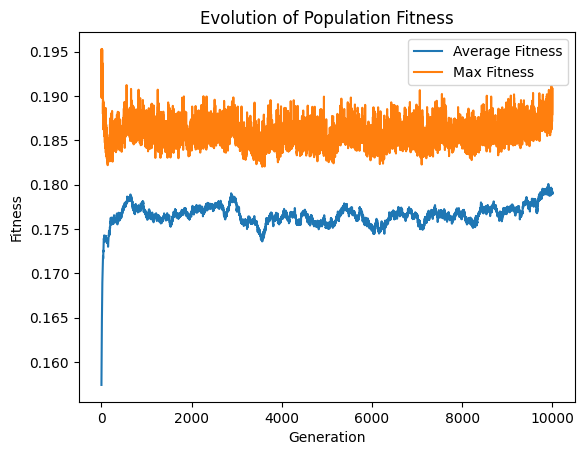

Best solution found: [0.009289576178724617, 0.6094932902818866, 0.11692563117102535, 0.26429150236836346], with fitness: 0.18793893077620902


In [18]:
# Параметры задачи
num_assets = 4  # Количество активов
expected_returns = [0.1, 0.2, 0.15, 0.18]  # Ожидаемые доходности активов
N = 5000  # Размер популяции

# Генерация начальной популяции
initial_population = generate_initial_population(N=N, num_assets=num_assets)

# Запуск генетического алгоритма
best_solution, fitness_history, max_fitness_history = genetic_algorithm(
    initial_population=initial_population,
    fitness_function=fitness_function,
    selection_function=roulette_selection,
    crossover_function=crossover,
    mutation_function=mutation,
    validate_function=validate_and_correct_population,
    expected_returns=expected_returns,
    N=N,
    max_generations=1000,  # Максимум 1000 поколений
    plateau_limit=15,     # Остановка на плато через 15 поколений
    step_by_step=False    # Пошаговый режим отключен
)

# Печать наилучшего решения
print(f"Best solution found: {best_solution.chromosome}, with fitness: {fitness_function(best_solution, expected_returns)}")